In [1]:
pip install goolge-api-python-client

ERROR: Could not find a version that satisfies the requirement goolge-api-python-client (from versions: none)
ERROR: No matching distribution found for goolge-api-python-client


In [6]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00


In [4]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.4 MB/s eta 0:00:00


In [2]:
pip install google-api-python-client

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# For Fetching Comments
from googleapiclient.discovery import build
# For filtering comments
import re
# For filtering comments with just emojis
import emoji
# Analyze the sentiments of the comment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For visualization
import matplotlib.pyplot as plt

**Step 3: Fetching Comments**

In [11]:
API_KEY = 'AIzaSyDAtaGC##############'# Put in your API Key

youtube = build('youtube', 'v3', developerKey=API_KEY) # initializing Youtube API

# Taking input from the user and slicing for video id
video_id = input('Enter Youtube Video URL: ')[-11:]
print("video id: " + video_id)

# Getting the channelId of the video uploader
video_response = youtube.videos().list(
    part='snippet',
    id=video_id
).execute()

# Splitting the response for channelID
video_snippet = video_response['items'][0]['snippet']
uploader_channel_id = video_snippet['channelId']
print("channel id: " + uploader_channel_id)

Enter Youtube Video URL: https://www.youtube.com/watch?v=avz06PDqDbM
video id: avz06PDqDbM
channel id: UCF9imwPMSGz4Vq1NiTWCC7g


In [12]:
# Fetch comments
print("Fetching Comments...")
comments = []
nextPageToken = None
while len(comments) < 600:
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        maxResults=100,  # You can fetch up to 100 comments per request
        pageToken=nextPageToken
    )
    response = request.execute()
    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        # Check if the comment is not from the video uploader
        if comment['authorChannelId']['value'] != uploader_channel_id:
            comments.append(comment['textDisplay'])
    nextPageToken = response.get('nextPageToken')

    if not nextPageToken:
        break
# Print the 5 comments
comments[:5]

Fetching Comments...


['This one was actually diarrhea crap',
 'It&#39;s time 2 pick up a side 7.14.23 in IMAX &amp; dolby cinema also in large format',
 'Estuvo chida',
 '&quot;Truth is vanishing, war is coming &quot;<br>Yeah.... welcome to 2024',
 'this time they have made it enormously massively larger than life']

**Step 4: Filtering Comments**

In [13]:
hyperlink_pattern = re.compile(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

threshold_ratio = 0.65

relevant_comments = []

# Inside your loop that processes comments
for comment_text in comments:

    comment_text = comment_text.lower().strip()

    emojis = emoji.emoji_count(comment_text)

    # Count text characters (excluding spaces)
    text_characters = len(re.sub(r'\s', '', comment_text))

    if (any(char.isalnum() for char in comment_text)) and not hyperlink_pattern.search(comment_text):
        if emojis == 0 or (text_characters / (text_characters + emojis)) > threshold_ratio:
            relevant_comments.append(comment_text)

# Print the relevant comments
relevant_comments[:5]

['this one was actually diarrhea crap',
 'it&#39;s time 2 pick up a side 7.14.23 in imax &amp; dolby cinema also in large format',
 'estuvo chida',
 '&quot;truth is vanishing, war is coming &quot;<br>yeah.... welcome to 2024',
 'this time they have made it enormously massively larger than life']

**Step 5: Storing comments in a text file for further access**

In [14]:
f = open("ytcomments.txt", 'w', encoding='utf-8')
for idx, comment in enumerate(relevant_comments):
    f.write(str(comment)+"\n")
f.close()
print("Comments stored successfully!")

Comments stored successfully!


**Step 6: Analyzing Comments**

In [15]:
def sentiment_scores(comment, polarity):

    # Creating a SentimentIntensityAnalyzer object.
    sentiment_object = SentimentIntensityAnalyzer()

    sentiment_dict = sentiment_object.polarity_scores(comment)
    polarity.append(sentiment_dict['compound'])

    return polarity


polarity = []
positive_comments = []
negative_comments = []
neutral_comments = []

f = open("ytcomments.txt", 'r', encoding='`utf-8')
comments = f.readlines()
f.close()
print("Analysing Comments...")
for index, items in enumerate(comments):
    polarity = sentiment_scores(items, polarity)

    if polarity[-1] > 0.05:
        positive_comments.append(items)
    elif polarity[-1] < -0.05:
        negative_comments.append(items)
    else:
        neutral_comments.append(items)

# Print polarity
polarity[:5]

Analysing Comments...


[-0.3818, 0.0, 0.0, -0.2263, 0.0]

**Step 7: Overall Polarity**

In [16]:
avg_polarity = sum(polarity)/len(polarity)
print("Average Polarity:", avg_polarity)
if avg_polarity > 0.05:
    print("The Video has got a Positive response")
elif avg_polarity < -0.05:
    print("The Video has got a Negative response")
else:
    print("The Video has got a Neutral response")

print("The comment with most positive sentiment:", comments[polarity.index(max(
    polarity))], "with score", max(polarity), "and length", len(comments[polarity.index(max(polarity))]))
print("The comment with most negative sentiment:", comments[polarity.index(min(
    polarity))], "with score", min(polarity), "and length", len(comments[polarity.index(min(polarity))]))

Average Polarity: 0.23351614420062708
The Video has got a Positive response
The comment with most positive sentiment: gerilim aksiyon savaş aşk heyecan dolu bir film izlemek için sabırsızlanıyorum sizlerde izlemeniz için tavsiye ederim ❤❤🎉❤🎉❤🎉❤
 with score 0.9836 and length 127
The comment with most negative sentiment: &quot;mission: impossible - dead reckoning&quot; could be considered as part of an action and espionage film series. the film may revolve around the adventures of the character ethan hunt, portrayed by tom cruise, in dangerous missions. as with other films in the series, high-paced action scenes, mysterious intrigues, and international espionage themes are expected.
 with score -0.6249 and length 369


***Plotting graphs***

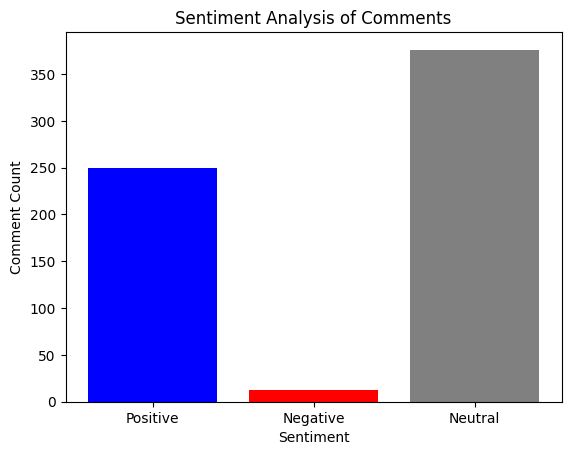

In [17]:
positive_count = len(positive_comments)
negative_count = len(negative_comments)
neutral_count = len(neutral_comments)

# labels and data for Bar chart
labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]

# Creating bar chart
plt.bar(labels, comment_counts, color=['blue', 'red', 'grey'])

# Adding labels and title to the plot
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')

# Displaying the chart
plt.show()

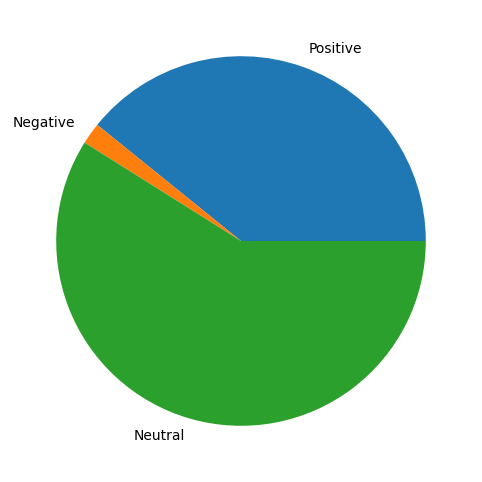

In [18]:
# labels and data for Bar chart
labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]

plt.figure(figsize=(10, 6)) # setting size

# plotting pie chart
plt.pie(comment_counts, labels=labels)

# Displaying Pie Chart
plt.show()

In [25]:
# Import TextBlob module for seminet analysis
from textblob import TextBlob

In [30]:
comments[0:5]

['this one was actually diarrhea crap\n',
 'it&#39;s time 2 pick up a side 7.14.23 in imax &amp; dolby cinema also in large format\n',
 'estuvo chida\n',
 '&quot;truth is vanishing, war is coming &quot;<br>yeah.... welcome to 2024\n',
 'this time they have made it enormously massively larger than life\n']

In [31]:
# finding sentiment polariy for the text
TextBlob('this one was actually diarrhea crap\n').sentiment.polarity

-0.4

In [34]:
# Creating empy list to store polarity values for all the comments
polarity = []
# iterating over comment text to find polatiy for all the comments, if any blank comment it there then in except it will take polariy as 0
for comment in comments:
    try:
        polarity.append(TextBlob(comment).sentiment.polarity)
    except:
        polarity.append(0)

In [49]:
#creating data frame for storing the comments and polarity related to it
comments = pd.DataFrame(comments,polarity)

In [81]:
comments.rename(columns={"Comments": "Comments_text"},inplace=True)

In [82]:
comments.head()

,Comments_text,polarity
-0.400000,this one was actually diarrhea crap\n,-0.400000
0.214286,it&#39;s time 2 pick up a side 7.14.23 in imax...,0.214286
0.000000,estuvo chida\n,0.000000
0.800000,"&quot;truth is vanishing, war is coming &quot;...",0.800000
0.000000,this time they have made it enormously massive...,0.000000


# Lets find count of positive, negative and neutral

In [83]:
# storing polarity greater than 0 into PositiveSentiment
PositiveSentiment = comments[comments['polarity'] > 0]
len(PositiveSentiment)

155

In [84]:
# Storing Negative Polarity i.e. polariyt < 0
NegativeSentiment = comments[comments["polarity"]<0]
len(NegativeSentiment)

11

In [85]:
NeutralSentiment = comments[comments['polarity']==0]
len(NegativeSentiment)

11

<Axes: ylabel='Frequency'>

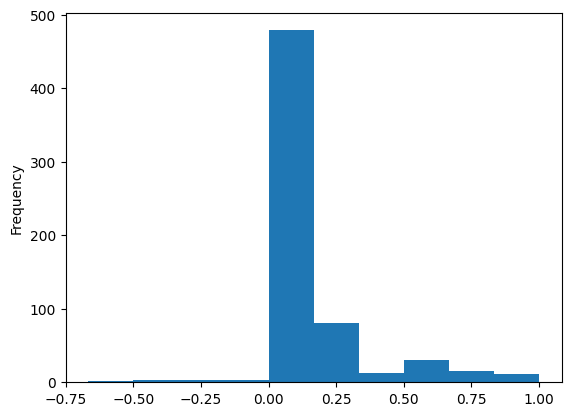

In [86]:
# Let's Polarity histogram
comments['polarity'].plot.hist()

# Conclusion: Here we can see that most of thepolartiy of comments ranges between 0.00 to 0.75
and Highest number of comment of having postive tendancy

# now lets Filter out the comments and creat word cluod

# Creating word  cloud for negative comments

In [87]:
# Creating filter for postive comments
filter1= comments['polarity'] ==1

In [88]:
comments_positive = comments[filter1]

In [89]:
comments_positive.head()

,Comments_text,polarity
1.0,perfect\n,1.0
1.0,it&#39;s a very beautiful movie\n,1.0
1.0,perfect tom cruise👍\n,1.0
1.0,perfect\n,1.0
1.0,perfect\n,1.0


In [90]:
# first creating filter to filter out negative comments and then storing that in comments_negative datafram
filter2=comments['polarity']==-1
comments_negative = comments[filter2]
comments_negative.head()

,Comments_text,polarity


In [91]:
# Now let's import wordcloud and STOPWORD module
from wordcloud import WordCloud, STOPWORDS

In [92]:
# Creating the set of STOPWORD s and store it
StopWord = set(STOPWORDS)

In [96]:
comments['Comments_text']

-0.400000                this one was actually diarrhea crap\n
 0.214286    it&#39;s time 2 pick up a side 7.14.23 in imax...
 0.000000                                       estuvo chida\n
 0.800000    &quot;truth is vanishing, war is coming &quot;...
 0.000000    this time they have made it enormously massive...
                                   ...                        
 0.000000                      i recommend everyone to watch\n
 0.056250                      a real extreme exciting movie\n
 0.000000    mükemmeliyet ötesi bir filmdi arkadaşlarıma at...
 0.000000                             eladi meslehet gorurem\n
 0.000000                                        woww harika\n
Name: Comments_text, Length: 638, dtype: object

In [97]:
# finding the type of comment text
type(comments['Comments_text'])

pandas.core.series.Series

In [98]:
# combining the comments text and converting it into string as it has serries
total_positive_comments = ''.join(comments_positive['Comments_text'])

In [99]:
# generates the word cloud total_positive_comments
wordcloud1 = WordCloud(stopwords=StopWord).generate(total_positive_comments)

(-0.5, 399.5, 199.5, -0.5)

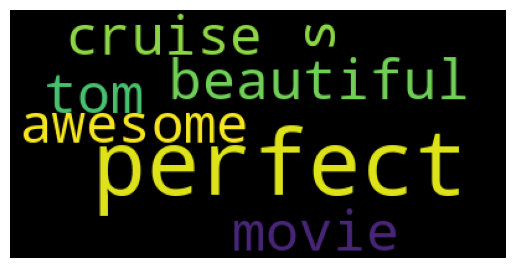

In [100]:
# lets plot wordcloud and remove axis
plt.imshow(wordcloud1)
plt.axis('off')

# In a same way we will create word cloud for negative sentiments

In [102]:
# Now we will combine all the negative comments in total_Negative_Comments
total_negative_comments = ''.join(comments_negative['Comments_text'])

In [105]:
wordcloud2 = WordCloud(stopwords=StopWord).generate(total_negative_comments)
plt.imshow(wordcloud2)
plt.axis('off')

ValueError: We need at least 1 word to plot a word cloud, got 0.

# now we will do emoji analysis

In [ ]:
import emoji

In [106]:
comments['Comments_text'].head()

-0.400000                this one was actually diarrhea crap\n
 0.214286    it&#39;s time 2 pick up a side 7.14.23 in imax...
 0.000000                                       estuvo chida\n
 0.800000    &quot;truth is vanishing, war is coming &quot;...
 0.000000    this time they have made it enormously massive...
Name: Comments_text, dtype: object

In [107]:
comment1 = ' trending 😉'

In [108]:
# lets try to extract the emoji from above text
[char for char in comment1 if char in emoji.EMOJI_DATA] #This is a code for list comprehension

['😉']

In [109]:
emoji_list = []
for char in comment1:
    if char in emoji.EMOJI_DATA:
        emoji_list.append(char)

In [110]:
emoji_list

['😉']

In [112]:
all_emoji_list = []
for comment in comments['Comments_text'].dropna():
    for char in comment:
        if char in emoji.EMOJI_DATA:
            all_emoji_list.append(char)

In [113]:
all_emoji_list[0:10]

['👽', '❤', '🎉', '🎉', '🎉', '❤', '😅', '🎉', '🎉', '🤗']

In [114]:
# importing counter moudle from collection package to count the count of emojis
from collections import Counter

In [115]:
Counter(all_emoji_list).most_common(10)

[('❤', 67),
 ('🎉', 56),
 ('👍', 36),
 ('🏻', 17),
 ('😊', 14),
 ('😮', 12),
 ('😍', 12),
 ('⭐', 5),
 ('👏', 4),
 ('👌', 3)]

In [116]:
Counter(all_emoji_list).most_common(10)[0]

('❤', 67)

In [117]:
Counter(all_emoji_list).most_common(10)[0][0]

'❤'

In [118]:
Counter(all_emoji_list).most_common(10)[1][1]

56

In [119]:
Counter(all_emoji_list).most_common(10)

[('❤', 67),
 ('🎉', 56),
 ('👍', 36),
 ('🏻', 17),
 ('😊', 14),
 ('😮', 12),
 ('😍', 12),
 ('⭐', 5),
 ('👏', 4),
 ('👌', 3)]

In [128]:
# here we are using for loop for iterate for collecting the emojis separately for plotting
emojis = [Counter(all_emoji_list).most_common(10)[i][0] for i in range(10)]

In [129]:
emojis

['❤', '🎉', '👍', '🏻', '😊', '😮', '😍', '⭐', '👏', '👌']

In [130]:
# here we are using for loop for iterate for collecting the frequesncy related to emoji separately for plotting
freqs = [Counter(all_emoji_list).most_common(10)[i][1] for i in range(10)]

In [131]:
freqs

[67, 56, 36, 17, 14, 12, 12, 5, 4, 3]

In [132]:
import plotly.graph_objs as go
from plotly.offline import iplot

In [133]:
trace = go.Bar(x=emojis,y=freqs)

In [134]:
iplot([trace])